Loads the averaged taxa embeddings (from Attribution_calculations.ipynb) and the vocabulary embeddings (from the paper "Decoding the language of microbiomes using word-embedding techniques, and applications in inflammatory bowel disease" / vocab_embeddings.npy), as well as the taxonomic assignments (from assign_16S_to_phyla.R), and generates the various TSNE-based plots of the embedding space geometry. It also generates plots to compare the clustering quality of the averaged embeddings and the vocabulary embeddings.

In [ ]:
import torch
import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt

!pip install --upgrade scikit-learn==1.1.3 --quiet
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn import metrics

In [ ]:
# Load the IBD dataset, labels, and vocab embeddings
ibdd = np.load("/path/to/total_IBD_512.npy")

labels = np.load('/path/to/total_IBD_label.npy')
labels = torch.from_numpy(labels).reshape(-1)

vocab_embeddings = np.load("/path/to/vocab_embeddings.npy")

# Load the taxonomic assignments
taxa_assignments = pd.read_csv("/path/to/r_taxa_assignments.csv")
taxa_assignments = taxa_assignments.replace(np.nan, 'nan')

current_cmap_str = "CMRmap" # use "viridis" for the more blue colored color map
top_n_samples_selected = 5000

# TSNE hyperparameters:
iterations = 1000
p = 100


In [ ]:
def load_dict_from_at_tensor(at_tensor):
    """
    Converts an attribution tensor into a dictionary of attributions for each microbe.

    Args:
    at_tensor (torch.Tensor): A tensor containing attribution information.
        Each row should contain:
        - sample_id (int): The ID of the sample
        - microbe_id (int): The ID of the microbe
        - attribution (float): The attribution score
        - base_score (float): The base score

    Returns:
    dict: A dictionary where each key is a microbe_id and each value is a list containing:
        - [0]: List of base scores for that microbe
        - [1]: List of attribution scores for that microbe
        - [2]: List of sample IDs associated with the scores
    """
    attributions = {}
    for i in range(len(at_tensor)):
        sample_id = int(at_tensor[i][0].item())
        microbe_id = int(at_tensor[i][1].item())
        attribution = at_tensor[i][2].item()
        base_score = at_tensor[i][3].item()
        if not microbe_id in attributions:
            attributions[microbe_id] = [[], [], []]
        attributions[microbe_id][0].append(base_score)
        attributions[microbe_id][1].append(attribution)
        attributions[microbe_id][2].append(sample_id)
    return attributions

#sh_at_tensor = torch.load('/path/to/Schirmer_attributions_e.pth')
#sh_attributions = load_dict_from_at_tensor(sh_at_tensor)

#hf_at_tensor = torch.load("/path/to/Halfvarson_attributions_e.pth")
#hf_attributions = load_dict_from_at_tensor(hf_at_tensor)

# Load and process IBD attributions
ibd_at_tensor = torch.load('/path/to/IBD_attributions_e.pth')
ibd_attributions = load_dict_from_at_tensor(ibd_at_tensor)
del ibd_at_tensor

# Calculate average attributions and counts for each microbe
counts_dict = {}
att_dict = {}
for ad in [ibd_attributions]:
    for m in ad.keys():
        if not m in counts_dict:
            counts_dict[m] = 0
            att_dict[m] = 0
        counts_dict[m] += len(ad[m][0])
        att_dict[m] += sum(ad[m][1])

# Calculate average attributions and sort microbes by count
avg_atts = [att_dict[k] / counts_dict[k] for k in att_dict.keys()]
counts = sorted([[k, counts_dict[k]] for k in counts_dict.keys()], reverse = True, key=lambda x : x[1])
microbes_to_embed = [m[0] for m in counts if m[0] != 0 and m[0] != 26727][:top_n_samples_selected]
microbe_atts = torch.tensor([att_dict[m] / counts_dict[m] for m in microbes_to_embed])

# Load model embeddings (from Attribution_calculations.ipynb)and calculate variances
embeddings = torch.load("/path/to/embeddings/epoch_" + str(120) + "_IBD_avg_vocab_embeddings.pth")
microbe_embeddings = embeddings[:, :, 0][microbes_to_embed]
squared_avg_microbe_embeddings = torch.pow(microbe_embeddings, 2)
avg_squared_microbe_embeddings = embeddings[:, :, 1][microbes_to_embed]
microbe_variances = torch.mean(avg_squared_microbe_embeddings - squared_avg_microbe_embeddings, axis=1)


# Load additional embedding statistics
process_results = torch.load("/path/to/embeddings/epoch_" + str(120) + "_IBD_embeddings_statistics.pth")
avg_cls_dim_variances = process_results[2]
avg_microbe_dim_variances = process_results[3]
variance_in_abundances = process_results[4]
pos_fracs = process_results[5]
m_counts = process_results[6]


# Normalize attribution scores for coloring
color_nums = microbe_atts
spread = max(color_nums[color_nums < 100]) - min(color_nums[color_nums > -100])
normed_atts = (color_nums - min(color_nums[color_nums > -100])) / spread
color_scores = 255 * normed_atts
color_scores = torch.minimum(torch.maximum(color_scores.to(torch.int), torch.zeros_like(color_scores)), 255 * torch.ones_like(color_scores))

Plot various vocab-level quantities against eachother:

In [ ]:


def get_coloring(color_nums, cmap_str = None):
    """
    Generates color scores and a ScalarMappable object for coloring based on the provided color numbers.

    Args:
    color_nums (torch.Tensor or list): A tensor or list of numbers representing color values.
    cmap_str (str, optional): The name of the colormap to use. Defaults to None.

    Returns:
    tuple: A tuple containing:
        - torch.Tensor: Normalized color scores scaled to the range 0-255.
        - matplotlib.cm.ScalarMappable: A ScalarMappable object configured with the provided colormap and normalization.
    """
    if type(color_nums) == list:
        color_nums = torch.tensor(color_nums)
    spread = max(color_nums[color_nums < 1000000000]) - min(color_nums[color_nums > -1000000000])
    normed_atts = (color_nums - min(color_nums[color_nums > -1000000000])) / spread
    color_scores = 255 * normed_atts
    color_scores = torch.minimum(torch.maximum(color_scores.to(torch.int), torch.zeros_like(color_scores)), 255 * torch.ones_like(color_scores))
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(color_nums[color_nums > -1000000000]), vmax=max(color_nums[color_nums < 1000000000])), cmap=cmap_str)
    return color_scores, sm

def rescale_sizes(sizes, max_output_size, min_output_size):
    """
    Rescales sizes to a specified range based on the input sizes.

    Args:
    sizes (torch.Tensor or list): A tensor or list of sizes to be rescaled.
    max_output_size (float): The maximum size to scale the input sizes to.
    min_output_size (float): The minimum size to scale the input sizes to.

    Returns:
    torch.Tensor: The rescaled sizes.
    """
    min_input_size = min(sizes)
    max_input_size = max(sizes)
    output_sizes = (max_output_size - min_output_size) * (sizes - min_input_size) / (max_input_size - min_input_size) + min_output_size
    return output_sizes

Prepare to generate various phylum-level info and interpretability results:

In [ ]:

def filter_dict_by_count(taxa_labelings, taxa_labels, count, level, max_index = 11):
    """
    Filters taxa labelings and labels based on a minimum count threshold for a given taxonomic level.

    Args:
    taxa_labelings (dict): A dictionary of taxa labelings.
    taxa_labels (list): A list of taxa labels.
    count (int): The minimum count threshold for each taxonomic level.
    level (str): The taxonomic level to filter by.
    max_index (int, optional): The maximum number of taxa to include in the filtered labelings. Defaults to 11.

    Returns:
    tuple: A tuple containing:
        - dict: The filtered taxa labelings.
        - list: The filtered taxa labels.
    """
    filtered_taxa_labels = []
    filtered_taxa_labelings = {"Other": [0, 0]}
    valid_indexes = []
    for name in taxa_labelings[level].keys():
        if taxa_labelings[level][name][1] >= count and len(valid_indexes) < max_index:
            filtered_index_value = taxa_labelings[level][name][0]
            filtered_taxa_labelings[name] = copy.deepcopy(taxa_labelings[level][name])
            filtered_taxa_labelings[name][0] = filtered_index_value
            valid_indexes.append(filtered_index_value)
    for j,i in enumerate(taxa_labels[level]):
        if i in valid_indexes:
            filtered_taxa_labels.append(i)
        else:
            filtered_taxa_labels.append(0)
            filtered_taxa_labelings["Other"][1] += 1
    return filtered_taxa_labelings, filtered_taxa_labels


def phylo_plot(embeddings,
               labelings,
               labels,
               plot_colors,
               title = None,
               save_name = None,
               legend_size = 2,
               legend_font_size = 10,
               legend_loc = 'best',
               highlight_selectors = None,
               highlight_labels = None,
               highlight_colors = None,
               csi = None,
               cmap_str = None,
               marker_size = 300,
               marker_width = 3,
               marker_symbol = "*",
               marker_fill_color = "None",
               s = 50,
               alpha = 0.8,
               borderpad = None):
    """
    Plots phylogenetic embeddings with optional highlighting and color mapping.

    Parameters:
    embeddings (array): Coordinates of the points to be plotted.
    labelings (dict): Dictionary mapping group names to indices.
    labels (array): Array of indices corresponding to the embeddings.
    plot_colors (list): List of colors for each group.
    title (str, optional): Title of the plot. Defaults to None.
    save_name (str, optional): Path to save the plot image. Defaults to None.
    legend_size (int, optional): Size of the legend. Defaults to 2.
    legend_font_size (int, optional): Font size of the legend text. Defaults to 10.
    legend_loc (str, optional): Location of the legend. Defaults to 'best'.
    highlight_selectors (list, optional): List of boolean arrays selecting points to highlight. Defaults to None.
    highlight_labels (list, optional): Labels for the highlighted points. Defaults to None.
    highlight_colors (list, optional): Colors for the highlighted points. Defaults to None.
    csi (array, optional): Color scaling information for non-categorical coloring. Defaults to None.
    cmap_str (str, optional): Colormap string for matplotlib. Defaults to None.
    marker_size (int or list, optional): Size of the markers. Defaults to 300.
    marker_width (int or list, optional): Line width of the marker edges. Defaults to 3.
    marker_symbol (str or list, optional): Symbol used for the markers. Defaults to "*".
    marker_fill_color (str or list, optional): Fill color for the markers. Can be 'None' or 'cmap' for colormap scaling. Defaults to "None".
    s (int, optional): Size of the points in the scatter plot. Defaults to 50.
    alpha (float, optional): Alpha value for the points. Defaults to 0.8.
    borderpad (float, optional): Padding around the border of the plot elements. Defaults to None.

    Returns:
    None: The function creates a plot and does not return any value.
    """
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    if csi is None:
        for i,group in enumerate(labelings.keys()):
            group_index = labelings[group][0]
            selector = labels == group_index
            plt.scatter(embeddings[:,0][selector], embeddings[:,1][selector], c=plot_colors[i], marker=".", label=group)
    else:
        color_scores, sm = get_coloring(csi, cmap_str)
        plt.scatter(embeddings[:,0], embeddings[:,1], c=color_scores, marker=".", alpha=alpha, s=s, cmap=cmap_str)
        plt.colorbar(sm)
    if not title is None:
        plt.title(title)
    #plt.ylim((3.5, 9.5))
    #plt.xlim((-7, -1))
    if not highlight_selectors is None:
        for i, (highlight_selector, label) in enumerate(zip(highlight_selectors, highlight_labels)):
            if type(marker_width) == list:
                current_marker_width = marker_width[i]
            else:
                current_marker_width = marker_width
            if type(marker_size) == list:
                current_marker_size = marker_size[i]
            else:
                current_marker_size = marker_size
            if type(marker_symbol) == list:
                current_marker_symbol = marker_symbol[i]
            else:
                current_marker_symbol = marker_symbol
            if type(marker_fill_color) == list:
                current_marker_fill_color = marker_fill_color[i]
            else:
                current_marker_fill_color = marker_fill_color

            if str.lower(current_marker_fill_color) == "cmap":
                current_marker_fill_color = color_scores[highlight_selector]
                current_cmap_str = cmap_str
            else:
                current_cmap_str = None

            plt.scatter(embeddings[:,0][highlight_selector],
                        embeddings[:,1][highlight_selector],
                        c=current_marker_fill_color,
                        edgecolors=highlight_colors[i],
                        linewidths = current_marker_width,
                        marker=current_marker_symbol,
                        label=label,
                        s=current_marker_size,
                        cmap = current_cmap_str)
    if legend_size > 0:
        plt.legend(markerscale=legend_size, prop={'size': legend_font_size}, borderpad=borderpad, loc=legend_loc)
    if not save_name is None:
        plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
# Initialize dictionaries to store taxonomic labelings and labels
taxa_labelings = {}
taxa_labels = {}

# Iterate through each taxonomic level (column) in the taxa_assignments dataframe
for c in taxa_assignments.columns:
    taxa_labelings[c] = {}
    taxa_labels[c] = []
    name_index = 1
    # Assign unique indices to each taxon within a level
    for i, l in enumerate(taxa_assignments[c]):
        # Check if the taxon is already in the dictionary
        if not l in taxa_labelings[c]:
            # Assign a new index and initialize the count for the taxon
            taxa_labelings[c][l] = [name_index, 0]
            name_index += 1
        taxa_labels[c].append(taxa_labelings[c][l][0])
        taxa_labelings[c][l][1] += 1

# Extract embeddings for the selected microbes from vocabulary embeddings
microbe_embeddings = vocab_embeddings[microbes_to_embed]
print("(iterations = " + str(iterations) + ", perplexity = " + str(p) + "):")
# Perform t-SNE dimensionality reduction on vocabulary embeddings
x = TSNE(perplexity=p, n_iter=iterations, angle=0.8, init='pca', early_exaggeration=22, learning_rate='auto', random_state=42).fit_transform(X=microbe_embeddings)

# Load contextualized embeddings
embeddings = torch.load("/path/to/embeddings/epoch_" + str(120) + "_IBD_avg_vocab_embeddings.pth")
microbe_embeddings = embeddings[microbes_to_embed][:,:,0]
print("(iterations = " + str(iterations) + ", perplexity = " + str(p) + "):")
# Perform t-SNE dimensionality reduction on contextualized embeddings
y = TSNE(perplexity=p, n_iter=iterations, angle=0.8, init='pca', early_exaggeration=22, learning_rate='auto', random_state=42).fit_transform(X=microbe_embeddings)

# Set up plotting parameters
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plot_colors = ['plum','salmon','darkgreen','blue','slategrey','purple','black','yellow', 'slategrey', 'darkgreen', "orange", "indigo"]
legend_size = 2
legend_font_size = 12

# Filter phylum-level labels based on a minimum count threshold
Phylum_labelings, Phylum_labels = filter_dict_by_count(taxa_labelings, taxa_labels, 450, "Phylum")
# Extract the labels for the plotted taxa
Phylum_labels_plotted_taxa = torch.tensor(Phylum_labels)[microbes_to_embed]

Actually start plotting phylum-level figures and interpretability results:

In [ ]:
Ruminococcaceae_selector = torch.tensor([taxa_assignments['Family'].iloc[microbes_to_embed[i]] == 'Ruminococcaceae' for i in range(top_n_samples_selected)])

phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by phylum (Ruminococcaceae marked)",
           save_name = "Contextualized_embeddings_phylum_Ruminococcaceae_marked.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Ruminococcaceae_selector],
           highlight_labels = ["Ruminococcaceae"],
           highlight_colors = ["black"],
           marker_size = 120,
           marker_width = 0.5)

phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by attribution (Ruminococcaceae marked)",
           save_name = "Contextualized_embeddings_attribution_Ruminococcaceae_marked.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Ruminococcaceae_selector],
           highlight_labels = ["Ruminococcaceae"],
           highlight_colors = ["black"],
           csi = microbe_atts,
           cmap_str = current_cmap_str,
           marker_size = 120,
           marker_width = 0.5,
           borderpad = 1)

In [ ]:
Ruminococcaceae_selector = torch.tensor([taxa_assignments['Family'].iloc[microbes_to_embed[i]] == 'Ruminococcaceae' for i in range(top_n_samples_selected)])
Ruminococcus_1_selector = torch.tensor([taxa_assignments['Genus'].iloc[microbes_to_embed[i]] == 'Ruminococcus_1' for i in range(top_n_samples_selected)])

phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = None, #"Contextualized embeddings colored by attribution",
           save_name = "Contextualized_embeddings_attribution_Ruminococcaceae_Ruminococcus_1_marked.pdf",
           legend_size = 1.5,
           legend_font_size = legend_font_size,
           highlight_selectors = [Ruminococcaceae_selector, Ruminococcus_1_selector],
           highlight_labels = ["Ruminococcaceae family", "Ruminococcus_1 taxa"],
           highlight_colors = ["black", "green"],
           csi = microbe_atts,
           cmap_str = current_cmap_str,
           marker_size = [50, 170],
           marker_width = [0.7, 2.2],
           marker_symbol = [".", "*"],
           marker_fill_color = ["None", "None"],
           s = 20,
           alpha = 0.3,
           borderpad = 0.5)

In [ ]:
Prevotellaceae_selector = torch.tensor([taxa_assignments['Family'].iloc[microbes_to_embed[i]] == 'Prevotellaceae' for i in range(top_n_samples_selected)])

Prevotella_9_selector = torch.tensor([taxa_assignments['Genus'].iloc[microbes_to_embed[i]] == 'Prevotella_9' for i in range(top_n_samples_selected)])
Prevotella_selector = torch.tensor([taxa_assignments['Genus'].iloc[microbes_to_embed[i]] == 'Prevotella' for i in range(top_n_samples_selected)])
Paraprevotella_selector = torch.tensor([taxa_assignments['Genus'].iloc[microbes_to_embed[i]] == 'Paraprevotella' for i in range(top_n_samples_selected)])

Bottom_Prevotella_9_selector = torch.tensor([microbes_to_embed[i] == 1013 for i in range(top_n_samples_selected)])
Bottom_Paraprevotella_selector = torch.tensor([microbes_to_embed[i] == 1074 for i in range(top_n_samples_selected)])
Bottom_Prevotella_selector = torch.tensor([microbes_to_embed[i] == 647 for i in range(top_n_samples_selected)])

phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by attribution (Prevotellaceae, Prevotella_9 marked)",
           save_name = "Contextualized_embeddings_attribution_Prevotellaceae_Prevotella_9_marked.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Prevotellaceae_selector, Prevotella_9_selector, Bottom_Prevotella_9_selector],
           highlight_labels = ["Prevotellaceae", "Prevotella_9", "Bottom Prevotella_9"],
           highlight_colors = ["black", "blue", "red"],
           csi = microbe_atts,
           cmap_str = current_cmap_str,
           marker_size = 120,
           marker_width = [0.5, 0.5, 2])

phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by attribution (Prevotellaceae, Prevotella marked)",
           save_name = "Contextualized_embeddings_attribution_Prevotellaceae_Prevotella_marked.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Prevotellaceae_selector, Prevotella_selector, Bottom_Prevotella_selector],
           highlight_labels = ["Prevotellaceae", "Prevotella", "Bottom Prevotella"],
           highlight_colors = ["black", "blue", "red"],
           csi = microbe_atts,
           cmap_str = current_cmap_str,
           marker_size = 120,
           marker_width = [0.5, 0.5, 2])


phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by attribution (Prevotellaceae, Paraprevotella marked)",
           save_name = "Contextualized_embeddings_attribution_Prevotellaceae_Paraprevotella_marked.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Prevotellaceae_selector, Paraprevotella_selector, Bottom_Paraprevotella_selector],
           highlight_labels = ["Prevotellaceae", "Paraprevotella", "Bottom Paraprevotella"],
           highlight_colors = ["black", "blue", "red"],
           csi = microbe_atts,
           cmap_str = current_cmap_str,
           marker_size = 120,
           marker_width = [0.5, 0.5, 2])


In [ ]:
Bottom_Prev_selector = Bottom_Prevotella_9_selector + Bottom_Paraprevotella_selector + Bottom_Prevotella_selector

phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = None, #"Contextualized embeddings colored by attribution",
           save_name = "Contextualized_embeddings_attribution_Prevotellaceae_bottom_Prevs_marked.pdf",
           legend_size = 1.5,
           legend_font_size = legend_font_size,
           highlight_selectors = [Prevotellaceae_selector, Bottom_Prev_selector],
           highlight_labels = ["Prevotellaceae family", "Bottom Prevotellaceae taxa"],
           highlight_colors = ["black", "green"],
           csi = microbe_atts,
           cmap_str = current_cmap_str,
           marker_size = [50, 170],
           marker_width = [0.7, 2.2],
           marker_symbol = [".", "*"],
           marker_fill_color = ["None", "None"],
           s = 20,
           alpha = 0.3)

In [ ]:
phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = None, #"Contextualized embeddings colored by attribution",
           save_name = "Contextualized_embeddings_attribution_Ruminococcaceae_Ruminococcus_1_marked.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Ruminococcaceae_selector, Ruminococcus_1_selector],
           highlight_labels = ["Ruminococcaceae", "Ruminococcus_1"],
           highlight_colors = ["black", "green"],
           csi = microbe_atts,
           cmap_str = current_cmap_str,
           marker_size = [50, 150],
           marker_width = [0.5, 1],
           marker_symbol = [".", "*"],
           marker_fill_color = ["None", "None"],
           s = 20,
           alpha = 0.3)

In [ ]:
phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = None,#"Contextualized embeddings colored by attribution (Prevotellaceae and bottom taxa marked)",
           save_name = "Contextualized_embeddings_attribution_Prevotellaceae_bottom_taxa_marked.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Prevotellaceae_selector, Bottom_Prevotella_9_selector, Bottom_Prevotella_selector, Bottom_Paraprevotella_selector],
           highlight_labels = ["Prevotellaceae", "Bottom Prevotella_9", "Bottom Prevotella", "Bottom Paraprevotella"],
           highlight_colors = ["black", "green", "green", "green"],
           csi = microbe_atts,
           cmap_str = current_cmap_str,
           marker_size = [50, 150, 150, 150],
           marker_width = [0.5, 3, 3, 3],
           marker_fill_color = ["None", "None", "None", "None"],
           marker_symbol = [".", "o", "X", "^"],
           alpha = 0.3)

In [ ]:
Prevotella_9_selector = torch.tensor([microbes_to_embed[i] == 1013 for i in range(top_n_samples_selected)])
Paraprevotella_selector = torch.tensor([microbes_to_embed[i] == 1074 for i in range(top_n_samples_selected)])
Prevotella_selector = torch.tensor([microbes_to_embed[i] == 647 for i in range(top_n_samples_selected)])

phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by phylum",
           save_name = "Contextualized_embeddings_phylum.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Prevotella_9_selector, Paraprevotella_selector, Prevotella_selector],
           highlight_labels = ["Prevotella_9", "Paraprevotella", "Prevotella"],
           highlight_colors = ["black", "red", "orange"])


phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by attribution",
           save_name = "Contextualized_embeddings_attribution.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           highlight_selectors = [Prevotella_9_selector, Paraprevotella_selector, Prevotella_selector],
           highlight_labels = ["Prevotella_9", "Paraprevotella", "Prevotella"],
           highlight_colors = ["black", "red", "orange"],
           csi = microbe_atts,
           cmap_str = current_cmap_str)

Plot embedding spaces at phylum, class, order, and family levels:

In [ ]:
legend_font_size = 12
legend_size = 4

Phylum_labelings, Phylum_labels = filter_dict_by_count(taxa_labelings, taxa_labels, 450, "Phylum")
Phylum_labels_plotted_taxa = torch.tensor(Phylum_labels)[microbes_to_embed]
phylo_plot(y,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           #title = "Contextualized embeddings colored by phylum",
           save_name = "Contextualized_embeddings_phylum.pdf",
           legend_size = 0,#legend_size,
           legend_font_size = legend_font_size)

phylo_plot(x,
           Phylum_labelings,
           Phylum_labels_plotted_taxa,
           plot_colors,
           #title = "Vocab embeddings colored by phylum",
           save_name = "Vocabulary_embeddings_phylum.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size,
           legend_loc = "lower right")

Class_labelings, Class_labels = filter_dict_by_count(taxa_labelings, taxa_labels, 250, "Class")
Class_labels_plotted_taxa = torch.tensor(Class_labels)[microbes_to_embed]

phylo_plot(y,
           Class_labelings,
           Class_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by class",
           save_name = "Contextualized_embeddings_class.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size)

phylo_plot(x,
           Class_labelings,
           Class_labels_plotted_taxa,
           plot_colors,
           title = "Vocab embeddings colored by class",
           save_name = "Vocabulary_embeddings_class.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size)


Order_labelings, Order_labels = filter_dict_by_count(taxa_labelings, taxa_labels, 450, "Order")
Order_labels_plotted_taxa = torch.tensor(Order_labels)[microbes_to_embed]

phylo_plot(y,
           Order_labelings,
           Order_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by order",
           save_name = "Contextualized_embeddings_order.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size)

phylo_plot(x,
           Order_labelings,
           Order_labels_plotted_taxa,
           plot_colors,
           title = "Vocab embeddings colored by order",
           save_name = "Vocabulary_embeddings_order.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size)

Family_labelings, Family_labels = filter_dict_by_count(taxa_labelings, taxa_labels, 600, "Family")
Family_labels_plotted_taxa = torch.tensor(Family_labels)[microbes_to_embed]

phylo_plot(y,
           Family_labelings,
           Family_labels_plotted_taxa,
           plot_colors,
           title = "Contextualized embeddings colored by family",
           save_name = "Contextualized_embeddings_family.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size)

phylo_plot(x,
           Family_labelings,
           Family_labels_plotted_taxa,
           plot_colors,
           title = "Vocab embeddings colored by family",
           save_name = "Vocabulary_embeddings_family.pdf",
           legend_size = legend_size,
           legend_font_size = legend_font_size)

Plot embedding spaces with different vocab highlighting:

In [ ]:
c_score_inputs = [microbe_atts, avg_cls_dim_variances, avg_microbe_dim_variances, torch.log(torch.tensor(m_counts)), torch.log(torch.tensor(variance_in_abundances)), torch.log(torch.tensor(pos_fracs))]
descs = ["attribution", "CLS variances", "microbe variance", "log frequency", "log abundance variance", "log fraction positive"]

for csi, d in zip(c_score_inputs, descs):
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    color_scores, sm = get_coloring(csi, cmap_str=current_cmap_str)
    plt.scatter(y[:,0], y[:,1], c=color_scores, marker=".", alpha=0.5, cmap=current_cmap_str)
    #plt.title("Contextualized embeddings (colored by " + d + ")")
    plt.colorbar(sm)
    plt.savefig("Contextualized embeddings (colored by " + d + ").pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    color_scores, sm = get_coloring(csi, cmap_str=current_cmap_str)
    plt.scatter(x[:,0], x[:,1], c=color_scores, marker=".", alpha=0.5, cmap=current_cmap_str)
    #plt.title("Vocab embeddings (colored by " + d + ")")
    plt.colorbar(sm)
    plt.savefig("Vocab embeddings (colored by " + d + ").pdf", bbox_inches='tight', pad_inches=0)
    plt.show()


Select vocab taxa by their locations in the embedding spaces:

In [ ]:
def select_by_rectangles(rects, x):
    """
    Selects points from an embedding space that fall within a set of rectangles.

    Args:
    rects (list): A list of rectangles, each defined by its lower-left and upper-right coordinates.
    x (array): Coordinates of the points to be selected.

    Returns:
    list: A list of indices of points that fall within at least one rectangle.
    """
    found = []
    for i in range(len(x)):
        i_x = x[i][0]
        i_y = x[i][1]
        valid = False
        for r in rects:
            r_ll_x = r[0][0]
            r_ll_y = r[0][1]
            r_ur_x = r[1][0]
            r_ur_y = r[1][1]
            if not(i_x < r_ll_x or i_x > r_ur_x or i_y < r_ll_y or i_y > r_ur_y):
                valid = True
        if valid:
            found.append(i)
    return found

def select_by_circles(circles, x):
    """
    Selects points from an embedding space that fall within a set of circles.

    Args:
    circles (list): A list of circles, each defined by its center and radius.
    x (array): Coordinates of the points to be selected.

    Returns:
    list: A list of indices of points that fall within at least one circle.
    """
    found = []
    for i in range(len(x)):
        i_x = x[i][0]
        i_y = x[i][1]
        valid = False
        for c in circles:
            cc_x = c[0][0]
            cc_y = c[0][1]
            r = c[1]
            if ((i_x - cc_x) ** 2 + (i_y - cc_y) ** 2 <= r ** 2):
                valid = True
        if valid:
            found.append(i)
    return found

Specifically, select the taxa at the high-attribution cluster in the center:

In [ ]:
circles = [[(-4, 6.5), 3]]
circle_select = select_by_circles(circles, y)
print(circle_select)

In [ ]:
color_scores, sm = get_coloring(microbe_atts, cmap_str=current_cmap_str)
plt.scatter(y[:,0], y[:,1], c=color_scores, marker=".", alpha=1, cmap=current_cmap_str)
#plt.scatter(y[:,0][circle_select], y[:,1][circle_select], marker="o", alpha=1, s=30, facecolors='none', edgecolors='green', label = "Selected")
fig = plt.gcf()
ax = fig.gca()
for c in circles:
    circle_image = plt.Circle(c[0], c[1], color='green', fill=False)
    ax.add_patch(circle_image)
plt.title("Contextualized embeddings (colored by attribution)")
plt.legend()
plt.colorbar(sm)
plt.show()

Plot mapping of select regions between vocab and contextualized embedding spaces:

In [ ]:
def plot_selected_taxa_assignments(rectangles,
                                   labelings,
                                   labels_plotted_taxa,
                                   x,
                                   y,
                                   space="vocab",
                                   title="plot",
                                   show_legend = False,
                                   add_center_cirle = False,
                                   highlight_size = 100,
                                   background_size = 4,
                                   background_alpha = 0.5,
                                   legend_marker_size = 2.4,
                                   legend_font_size = 12,
                                   legend_loc = "lower right"):
    """
    Plots selected taxa assignments in both vocabulary and contextualized embedding spaces, using rectangles to select points to be highlighted.

    Parameters:
    rectangles (list of tuples): List of rectangle coordinates used for selecting data points.
    labelings (dict): Dictionary mapping group names to their respective indices.
    labels_plotted_taxa (array): Array of indices corresponding to taxa labels.
    x (array): Data points in the vocabulary space.
    y (array): Data points in the contextualized embedding space.
    space (str): Specifies the space ('vocab' or other) to apply rectangle selection.
    title (str): Title for the plot, used in saving the file.
    show_legend (bool): Flag to show or hide the legend in the plot.
    add_center_cirle (bool): Flag to add a center circle marker on selected points.
    highlight_size (int): Size of the markers for highlighted points.
    background_size (int): Size of the markers for background points.
    background_alpha (float): Transparency level of background markers.
    legend_marker_size (float): Scale of markers in the legend.
    legend_font_size (int): Font size of the legend text.
    legend_loc (str): Location of the legend on the plot.

    Outputs:
    Two plots are generated and saved. One for the vocabulary space and one for the contextualized embedding space.
    Each plot highlights selected data points according to the provided rectangles and groups.
    """
    num_datapoints = len(x)
    fig, ax = plt.subplots()
    if space == "vocab":
        found = torch.tensor(select_by_rectangles(rectangles, x))
    else:
        found = torch.tensor(select_by_rectangles(rectangles, y))
    for group in labelings.keys():
        group_index = labelings[group][0]
        group_selector = labels_plotted_taxa == group_index
        plt.scatter(x[:,0][group_selector], x[:,1][group_selector], c=plot_colors[group_index], marker=".", s=background_size, alpha=background_alpha)

    for group in labelings.keys():
        group_index = labelings[group][0]
        group_selector = labels_plotted_taxa == group_index
        location_selector = torch.sum(torch.nn.functional.one_hot(found, num_classes = num_datapoints), dim=0).to(torch.bool)
        selector = group_selector & location_selector
        plt.scatter(x[:,0][selector], x[:,1][selector], c=plot_colors[group_index], marker=".", s=highlight_size, label=group)
        if add_center_cirle:
            plt.scatter(x[:,0][selector], x[:,1][selector], c="black", marker="x", s=4)
    if show_legend:
        plt.legend(markerscale=legend_marker_size, prop={'size': legend_font_size}, loc=legend_loc)
    ax.set_xticks([])
    ax.set_yticks([])
    #fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.savefig("vocab_" + title + ".tiff", bbox_inches='tight', pad_inches=0)
    plt.show()

    fig, ax = plt.subplots()
    for group in labelings.keys():
        group_index = labelings[group][0]
        group_selector = labels_plotted_taxa == group_index
        plt.scatter(y[:,0][group_selector], y[:,1][group_selector], c=plot_colors[group_index], marker=".", s=background_size, alpha=background_alpha)

    for group in labelings.keys():
        group_index = labelings[group][0]
        group_selector = labels_plotted_taxa == group_index
        location_selector = torch.sum(torch.nn.functional.one_hot(found, num_classes = num_datapoints), dim=0).to(torch.bool)
        selector = group_selector & location_selector
        plt.scatter(y[:,0][selector], y[:,1][selector], c=plot_colors[group_index], marker=".", s=highlight_size, label=group)
        if add_center_cirle:
            plt.scatter(y[:,0][selector], y[:,1][selector], c="black", marker=".", s=4)
    ax.set_xticks([])
    ax.set_yticks([])
    #fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.savefig("embed_" + title + ".tiff", bbox_inches='tight', pad_inches=0)
    plt.show()



/content/MB_plots


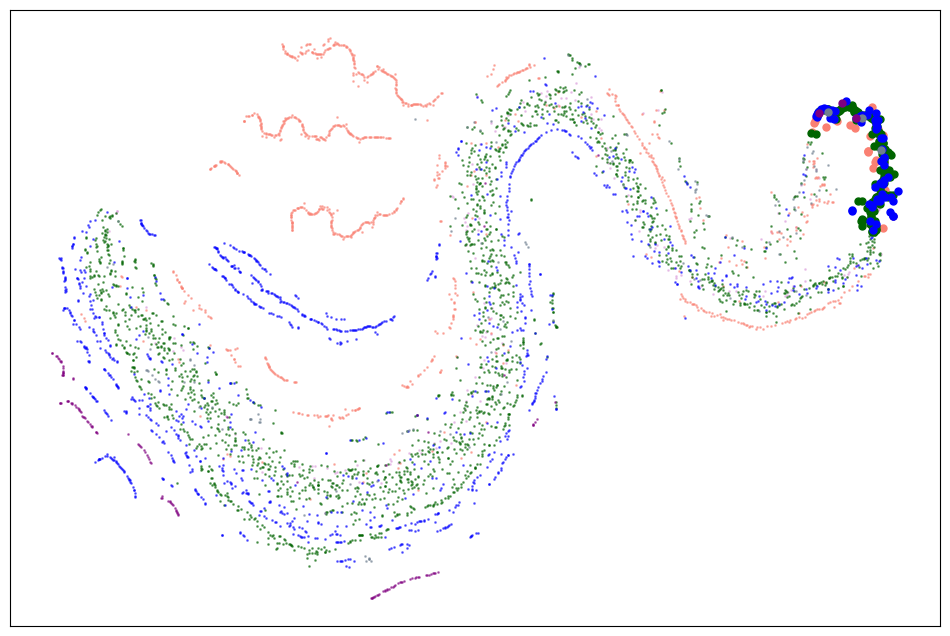

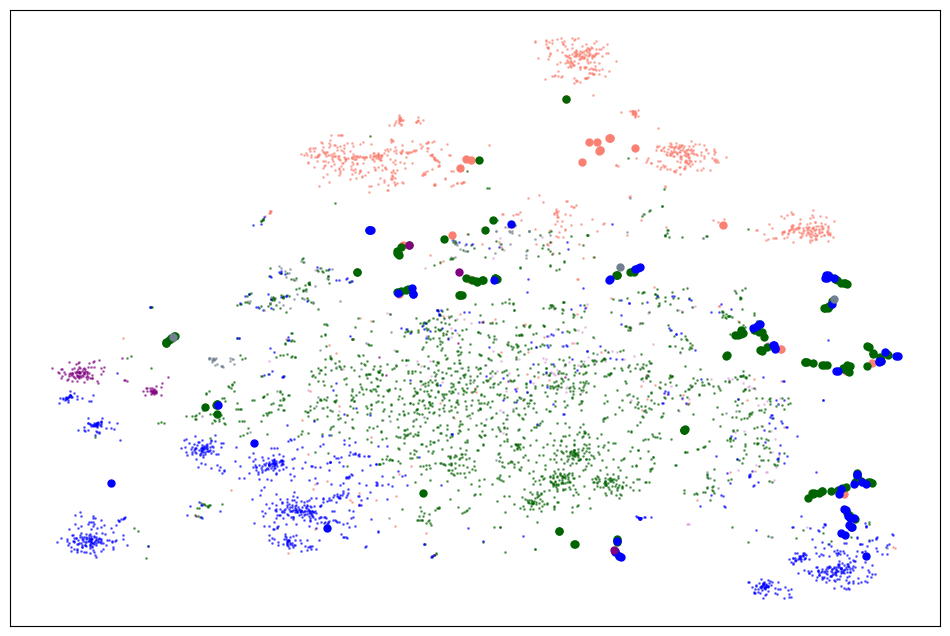

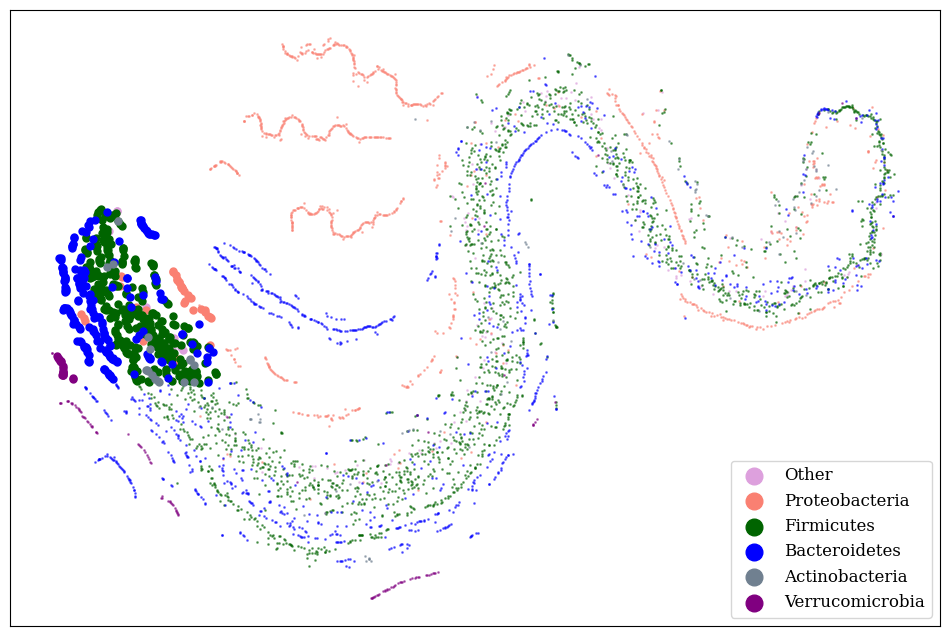

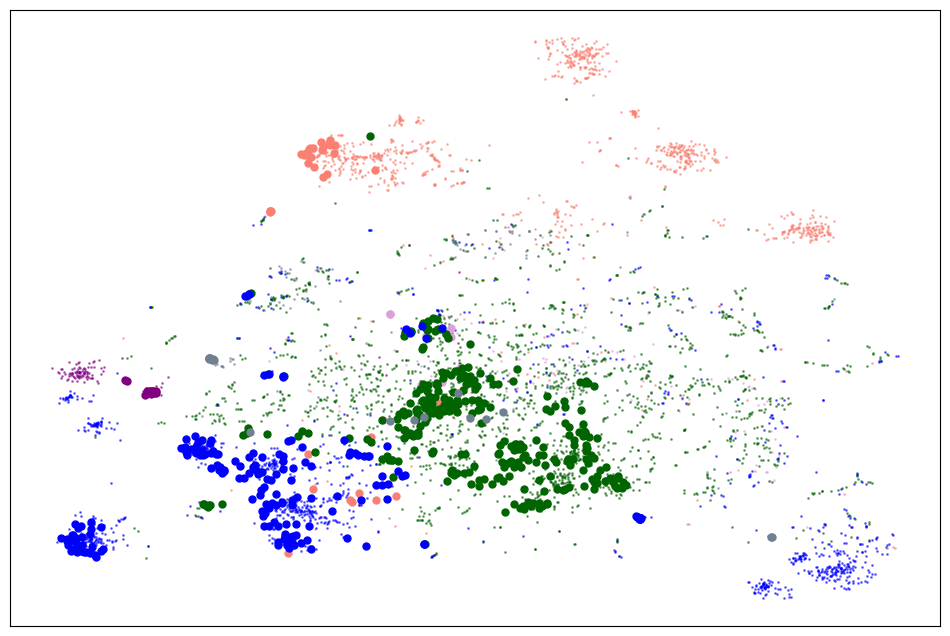

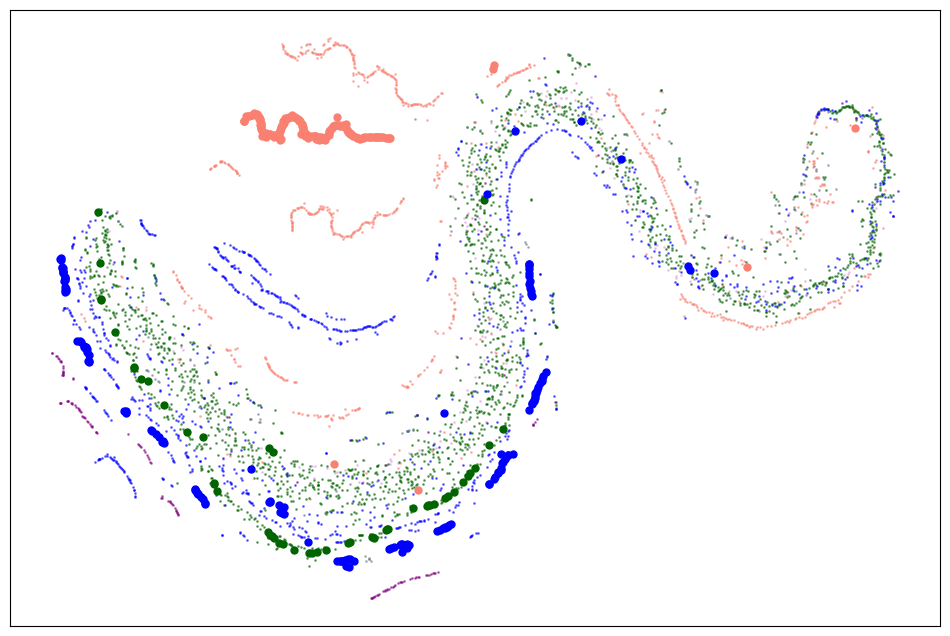

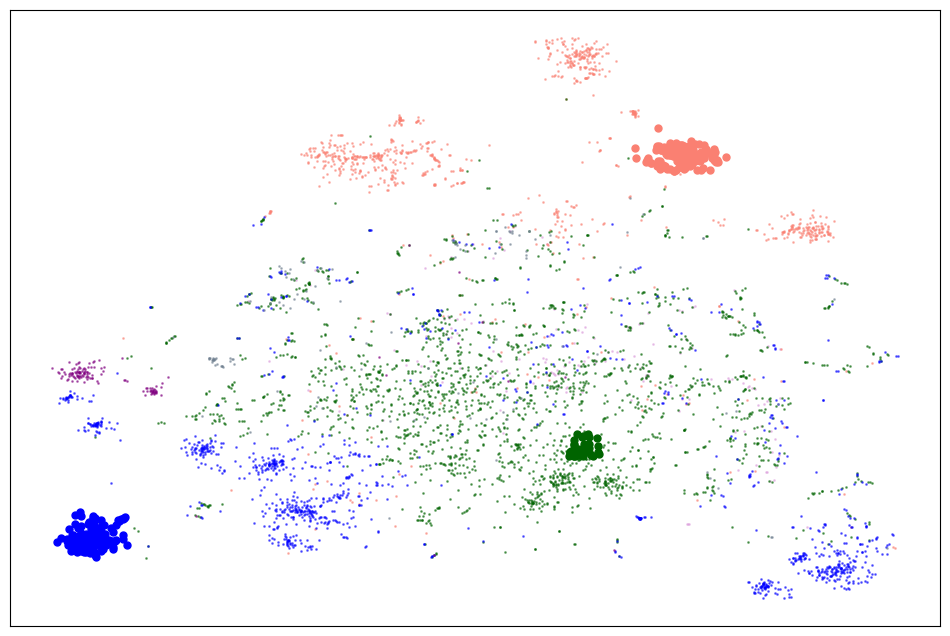

/content
  adding: MB_plots/ (stored 0%)
  adding: MB_plots/vocab_3_squiggles_phylum_highlight.tiff (deflated 98%)
  adding: MB_plots/embed_submanifold_segment_2_phylum_highlight_with_legend.tiff (deflated 98%)
  adding: MB_plots/vocab_submanifold_segment_2_phylum_highlight_with_legend.tiff (deflated 97%)
  adding: MB_plots/embed_3_squiggles_phylum_highlight.tiff (deflated 98%)
  adding: MB_plots/vocab_dense_region_phylum_highlight.tiff (deflated 98%)
  adding: MB_plots/embed_dense_region_phylum_highlight.tiff (deflated 98%)


In [ ]:
#plot_colors = ['fuchsia','red','darkgreen','blue','slategrey','purple']
#plot_colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
!rm -rf MB_plots*
!mkdir MB_plots
%cd MB_plots
#plot_selected_taxa_assignments([[[9,27],[30,33]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="embedding", title = "squiggle_phylum_highlight")
plot_selected_taxa_assignments([[[45,16],[60,30]], [[50,6],[60,30]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="vocab", title = "dense_region_phylum_highlight")
#plot_selected_taxa_assignments([[[40,3],[47,15]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="vocab", title = "less_dense_region_phylum_highlight")
#plot_selected_taxa_assignments([[[-30,-30],[-23,-15]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="embedding", title = "squiggle_1_phylum_highlight")
#plot_selected_taxa_assignments([[[5,-10],[7,-7]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="embedding", title = "submanifold_1_phylum_highlight")
#plot_selected_taxa_assignments([[[-19,-11],[-17,-8]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="embedding", title = "submanifold_2_phylum_highlight")
#plot_selected_taxa_assignments([[[-19,-14],[-9,-12]], [[-4,-11],[0,-1]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="vocab", title = "submanifold_segment_1_phylum_highlight")
#plot_selected_taxa_assignments([[[-45,-10],[-25,-2]], [[-45,-5],[-29,10]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="vocab", title = "submanifold_segment_2_phylum_highlight")
plot_selected_taxa_assignments([[[-45,-10],[-25,-2]], [[-45,-5],[-29,10]]], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="vocab", show_legend=True, title = "submanifold_segment_2_phylum_highlight_with_legend")

#plot_selected_taxa_assignments([[[9,27],[30,33]], [[-30,-30],[-23,-15]]   ], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="embedding", title = "2_squiggles_phylum_highlight")
plot_selected_taxa_assignments([[[9,27],[30,33]], [[-30,-30],[-23,-15]], [[5,-10],[7,-7]]   ], Phylum_labelings, Phylum_labels_plotted_taxa, x, y, space="embedding", title = "3_squiggles_phylum_highlight")

%cd ..
!rm -rf MB_plots.zip
!zip -r MB_plots.zip MB_plots

In [ ]:
!zip -r MB_plots.zip MB_plots

updating: MB_plots/ (stored 0%)
updating: MB_plots/vocab_submanifold_2_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/embed_3_squiggles_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/vocab_squiggle_1_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/embed_submanifold_segment_1_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/vocab_squiggle_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/embed_dense_region_phylum_highlight.pdf (deflated 4%)
updating: MB_plots/embed_submanifold_2_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/embed_squiggle_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/embed_submanifold_1_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/vocab_dense_region_phylum_highlight.pdf (deflated 4%)
updating: MB_plots/embed_submanifold_segment_2_phylum_highlight_with_legend.pdf (deflated 4%)
updating: MB_plots/embed_2_squiggles_phylum_highlight.pdf (deflated 3%)
updating: MB_plots/vocab_less_dense_region_phylum_highlight.pdf (deflat

Plot the clustering quality measures for the vocabulary and contextualized embedding spaces:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


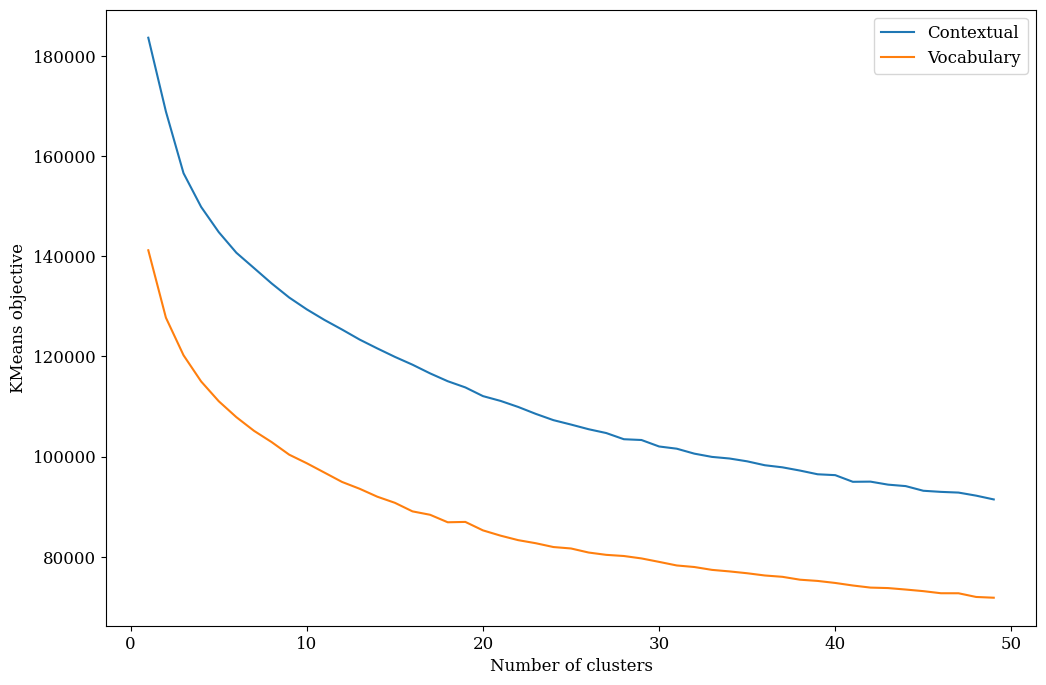

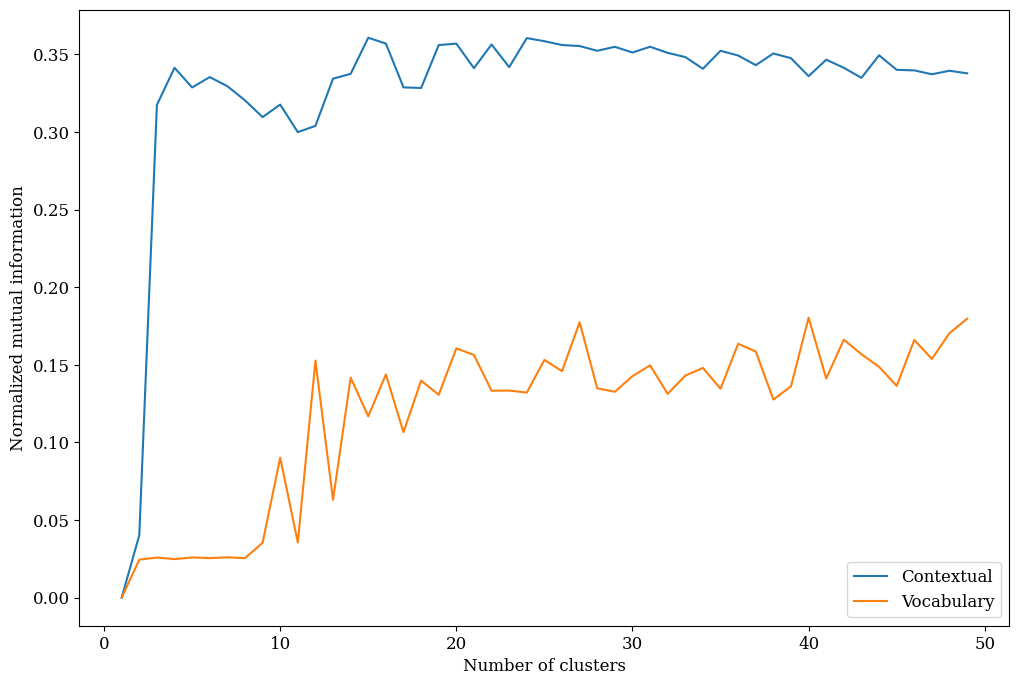

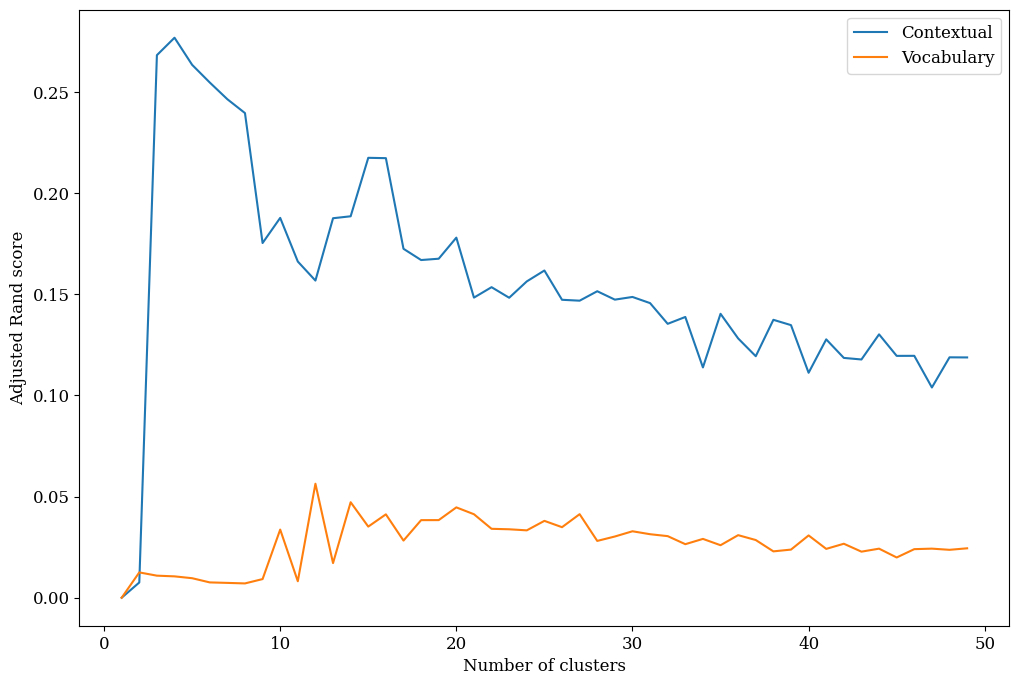

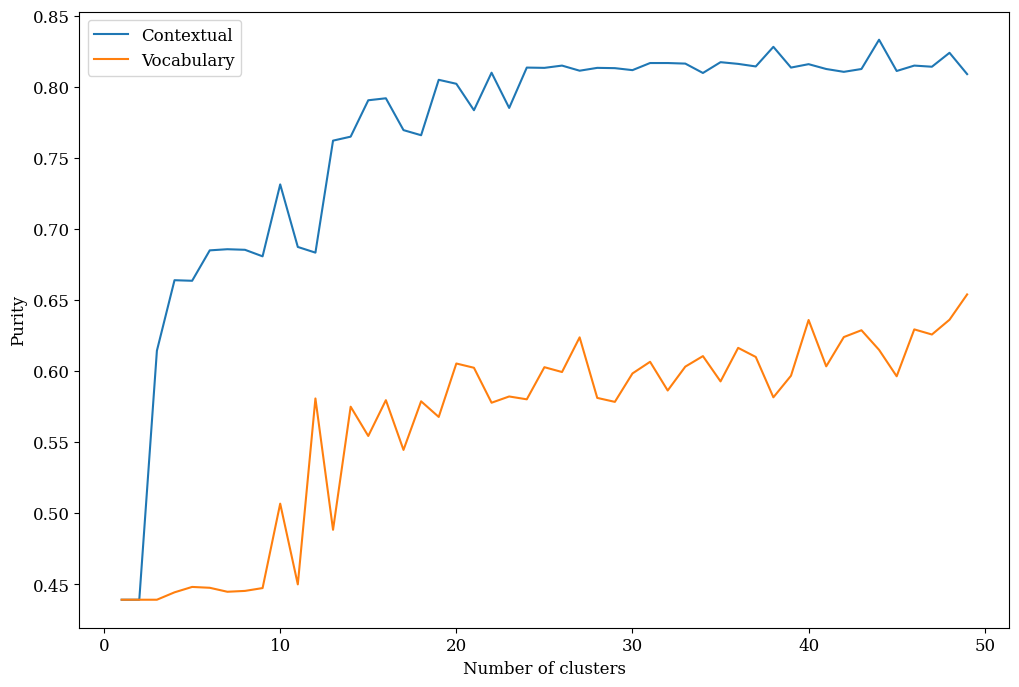

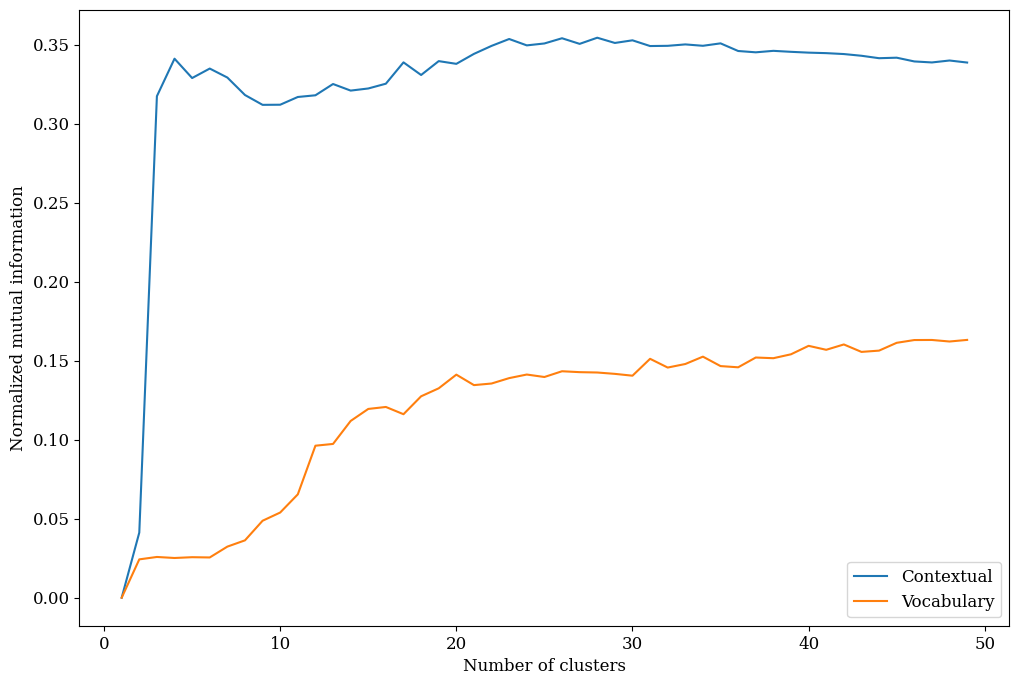

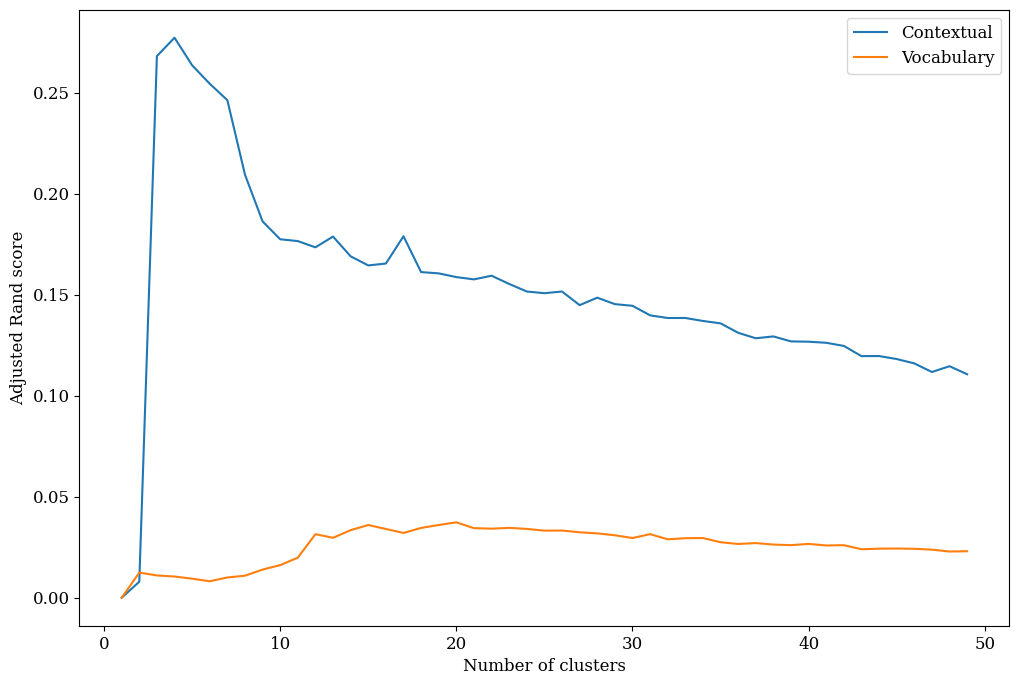

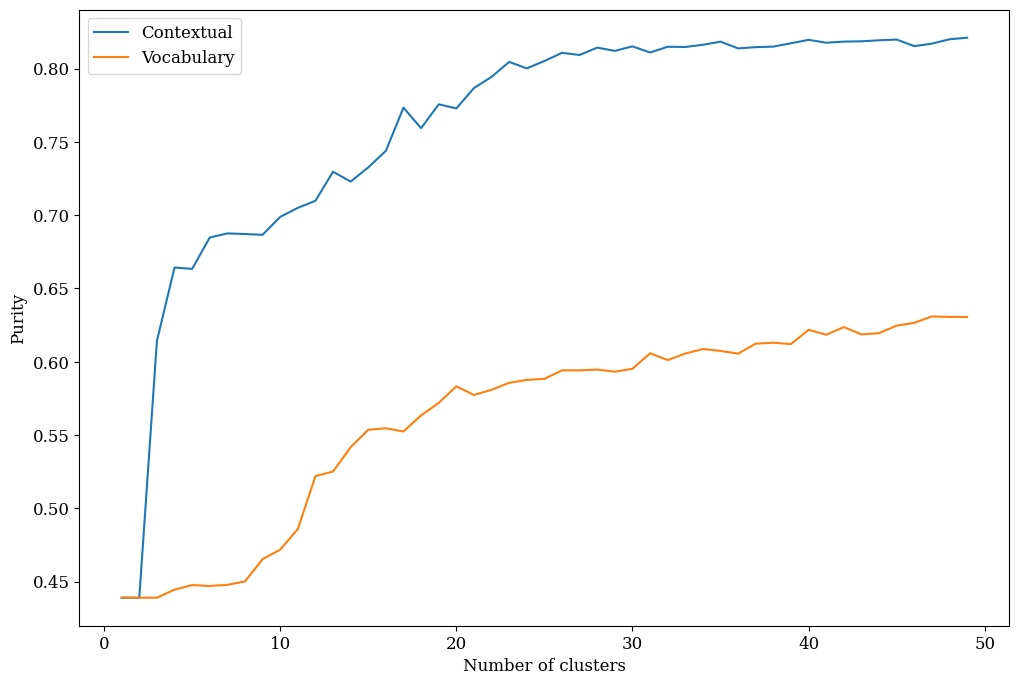

In [ ]:
# From https://stackoverflow.com/a/51672699/18956769
def purity_score(y_true, y_pred):
    """
    Calculate the purity score for clustering results.
    
    Args:
    y_true (array-like): True labels
    y_pred (array-like): Predicted cluster labels
    
    Returns:
    float: Purity score
    """
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Load contextual embeddings
embeddings = torch.load("/path/to/embeddings/epoch_" + str(120) + "_IBD_avg_vocab_embeddings.pth")
contextual_embeddings = embeddings[microbes_to_embed][:,:,0]

# Load vocabulary embeddings
vocab_embeddings = np.load("/path/to/vocab_embeddings.npy")
fixed_embeddings = vocab_embeddings[microbes_to_embed]

# Filter phylum labels based on a small minimum count threshold to get the cluster labels
Phylum_x_labelings, Phylum_x_labels = filter_dict_by_count(taxa_labelings, taxa_labels, 10, "Phylum")
cluster_labels = torch.tensor(Phylum_x_labels)[microbes_to_embed]


# Set up parameters for clustering evaluation
N = 50  # Maximum number of clusters
M = 20  # Number of runs for averaging results

# Initialize arrays to store results
objectives_f_array = [0 for _ in range(1, N)]
nmis_f_array = [0 for _ in range(1, N)]
arss_f_array = [0 for _ in range(1, N)]
purities_f_array = [0 for _ in range(1, N)]

objectives_c_array = [0 for _ in range(1, N)]
nmis_c_array = [0 for _ in range(1, N)]
arss_c_array = [0 for _ in range(1, N)]
purities_c_array = [0 for _ in range(1, N)]

# Perform multiple runs of clustering evaluation
for run in range(0, M):
    print(run)
    objectives_f = []
    nmis_f = []
    arss_f = []
    purities_f = []

    objectives_c = []
    nmis_c = []
    arss_c = []
    purities_c = []


    # Evaluate clustering for different numbers of clusters
    for n in range(1, N):
        # Clustering for fixed (vocabulary) embeddings
        kmeans = KMeans(n_clusters=n).fit(X=fixed_embeddings)
        objectives_f.append(kmeans.inertia_)
        pred_labels = kmeans.predict(fixed_embeddings)
        nmi = normalized_mutual_info_score(cluster_labels, pred_labels)
        nmis_f.append(nmi)
        ars = adjusted_rand_score(cluster_labels, pred_labels)
        arss_f.append(ars)
        purity = purity_score(cluster_labels, pred_labels)
        purities_f.append(purity)

        # Accumulate results for averaging
        purities_f_array[n-1] += purity / M
        arss_f_array[n-1] += ars / M
        nmis_f_array[n-1] += nmi / M

        # Clustering for contextualized embeddings
        kmeans = KMeans(n_clusters=n).fit(X=contextual_embeddings)
        objectives_c.append(kmeans.inertia_)
        pred_labels = kmeans.predict(contextual_embeddings)
        nmi = normalized_mutual_info_score(cluster_labels, pred_labels)
        nmis_c.append(nmi)
        ars = adjusted_rand_score(cluster_labels, pred_labels)
        arss_c.append(ars)
        purity = purity_score(cluster_labels, pred_labels)
        purities_c.append(purity)

        # Accumulate results for averaging
        purities_c_array[n-1] += purity / M
        arss_c_array[n-1] += ars / M
        nmis_c_array[n-1] += nmi / M

# Plot the clustering quality measures for the vocabulary and contextualized embedding spaces
plt.plot(range(1, N), objectives_c, label = "Contextual")
plt.plot(range(1, N), objectives_f, label = "Vocabulary")
plt.xlabel("Number of clusters")
plt.ylabel("KMeans objective")
plt.legend()
plt.show()

# Plot Normalized Mutual Information
plt.plot(range(1, N), nmis_c, label = "Contextual")
plt.plot(range(1, N), nmis_f, label = "Vocabulary")
plt.xlabel("Number of clusters")
plt.ylabel("Normalized mutual information")
plt.legend()
plt.show()

# Plot Adjusted Rand Score
plt.plot(range(1, N), arss_c, label = "Contextual")
plt.plot(range(1, N), arss_f, label = "Vocabulary")
plt.xlabel("Number of clusters")
plt.ylabel("Adjusted Rand score")
plt.legend()
plt.show()

# Plot Purity
plt.plot(range(1, N), purities_c, label = "Contextual")
plt.plot(range(1, N), purities_f, label = "Vocabulary")
plt.xlabel("Number of clusters")
plt.ylabel("Purity")
plt.legend()
plt.show()

# Plot Normalized Mutual Information
plt.plot(range(1, N), nmis_c_array, label = "Contextual")
plt.plot(range(1, N), nmis_f_array, label = "Vocabulary")
plt.xlabel("Number of clusters")
plt.ylabel("Normalized mutual information")
plt.legend()
plt.savefig("Clustering_plots/clustering_normalized_mutual_info.tiff")
plt.show()

# Plot averaged Adjusted Rand Score
plt.plot(range(1, N), arss_c_array, label = "Contextual")
plt.plot(range(1, N), arss_f_array, label = "Vocabulary")
plt.xlabel("Number of clusters")
plt.ylabel("Adjusted Rand score")
plt.legend()
plt.savefig("Clustering_plots/clustering_adjusted_rand_score.tiff")
plt.show()

# Plot averaged Purity
plt.plot(range(1, N), purities_c_array, label = "Contextual")
plt.plot(range(1, N), purities_f_array, label = "Vocabulary")
plt.xlabel("Number of clusters")
plt.ylabel("Purity")
plt.legend()
plt.savefig("Clustering_plots/clustering_purity.tiff")
plt.show()